<a href="https://colab.research.google.com/github/tiborio/FIDE-predictions/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Data Mining Final Project - Predicting FIDE Ratings*

Abel R. Yera

The chosen dataset consists of international chess statistics for the year 2022 retrieved from chess-ranking.com. The dataset can be found [here](https://www.kaggle.com/datasets/deepcontractor/international-chess-statistics-2022)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import math
import os
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

Loading the Dataset

In [ ]:
path = 'Complete_Players_Database.csv'
FIDE = pd.read_csv(path)

<ipython-input-17-0a45b05724cc>:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  FIDE = pd.read_csv(path)


# Data Inspection

We first look at the size of the dataset.

In [ ]:
print("\nDataset size: ", FIDE.shape)

In [ ]:
print(f"Number of rows: {FIDE.shape[0]}")
print(f"Number of cols: {FIDE.shape[1]}")
FIDE.describe().T
FIDE.info()

Considering there are only a few features, we will not be omitting any, instead, we will add some later on.

There are 4 out of the 7 features that are categorical. However, FIDE Ratings should be numerical, except for the unranked/unrated players, for which we need to standardize the column.

In [ ]:
FIDE['FIDE'] = pd.to_numeric(FIDE['FIDE'], errors = 'coerce')

Now we check for null values.

In [ ]:
FIDE.isnull().sum()

Seeing there are so many NaN values, we will predict these values later using specific models.

Now we check for duplicates

In [ ]:
FIDE.duplicated().sum()

In [ ]:
all_classes = FIDE['Title'].unique()

for class_name in all_classes:
    print(f"Percentage of {class_name} class in dataset: {FIDE[FIDE['Title'] == class_name]['Title'].size/FIDE['Title'].size*100:0.2f}%")

We see this problem arise again here, where the majority of the dataset holds unrated/unranked players.

Basic statistics:

In [ ]:
print(FIDE.describe())

Additionally, I would like to analyze the mode for age and FIDE rankings, to have
another statistic than can prompt insightful conclusions.

In [ ]:
print(f"Mode of FIDE Ratings: {FIDE['FIDE'].mode()[0]}")
print(f"Mode of Age: {FIDE['Age'].mode()[0]}")

There is only one category left that can be analyzed which is Title, since the name of a person does not hold much statistical value in this case. We will look at its distribution.

In [ ]:
print(FIDE['Title'].value_counts())

Finally, we will check for correlation.

In [ ]:
numeric_cols = FIDE.select_dtypes(include=[np.number])
correlation_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

We can see a strong negative correlation between Country Rank and FIDE Rating, and even stronger correlation between FIDE Rating and K-factor, among others.

In [ ]:
target_correlations = numeric_cols.corrwith(numeric_cols['FIDE']).sort_values()

plt.figure(figsize=(12, 6))
target_correlations.drop('FIDE', inplace=True)
sns.barplot(x=target_correlations.index, y=target_correlations.values, palette='coolwarm')
plt.title('Correlation of Features with FIDE Ratings')
plt.xticks(rotation=45)
plt.show()

# Data Visualization

Before dealing with the potential outliers and inconsistencies, we will utilize some tools
to visualize and get a better idea of the data we have so far.

Since the data is so spread for the Country feature, I will simply create a bar graph showing the top 20 countries by number of chess players and a map showing the density by country.

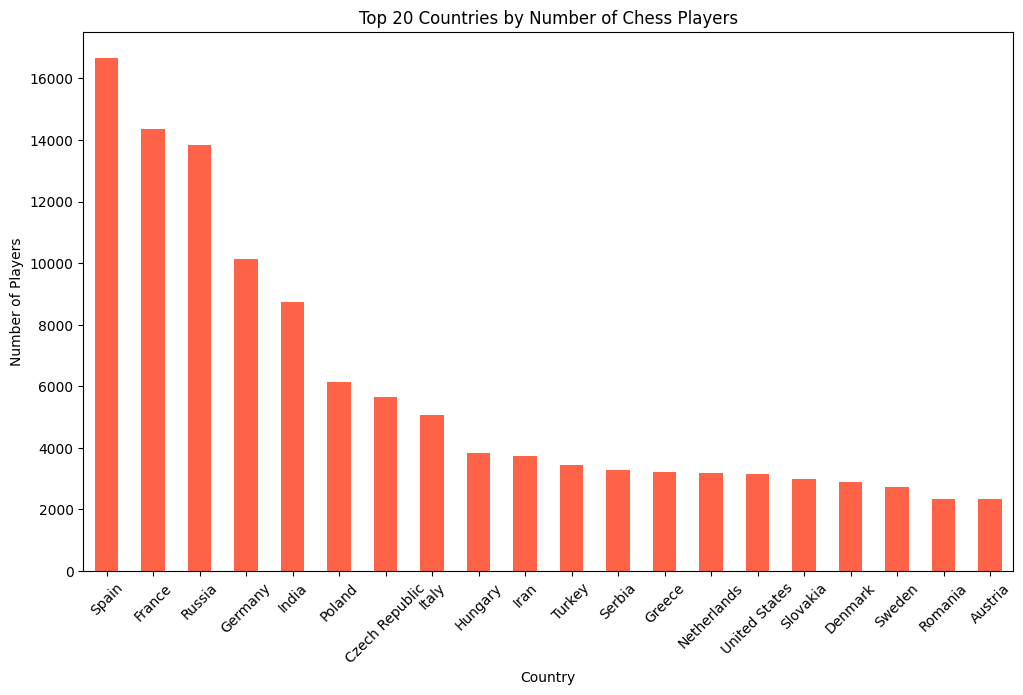

In [ ]:
plt.figure(figsize=(12, 7))
top_countries = FIDE['Country'].value_counts().head(20)
top_countries.plot(kind='bar', color='tomato')
plt.title('Top 20 Countries by Number of Chess Players')
plt.xlabel('Country')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.show()

players_per_country = FIDE['Country'].value_counts().reset_index()
players_per_country.columns = ['Country', 'PlayerCount']
fig = px.choropleth(players_per_country,
                    locations='Country',
                    locationmode='country names',
                    color='PlayerCount',
                    color_continuous_scale=px.colors.sequential.Magma,
                    title='Global Distribution of Chess Players')

fig.show()

Since FIDE Ratings is the main feature, I chose a histogram to identify the skewness
of the data and its modality. It is a good visualization as well for range
and variation of player skill levels when looking at the width of the graph
and its spread.

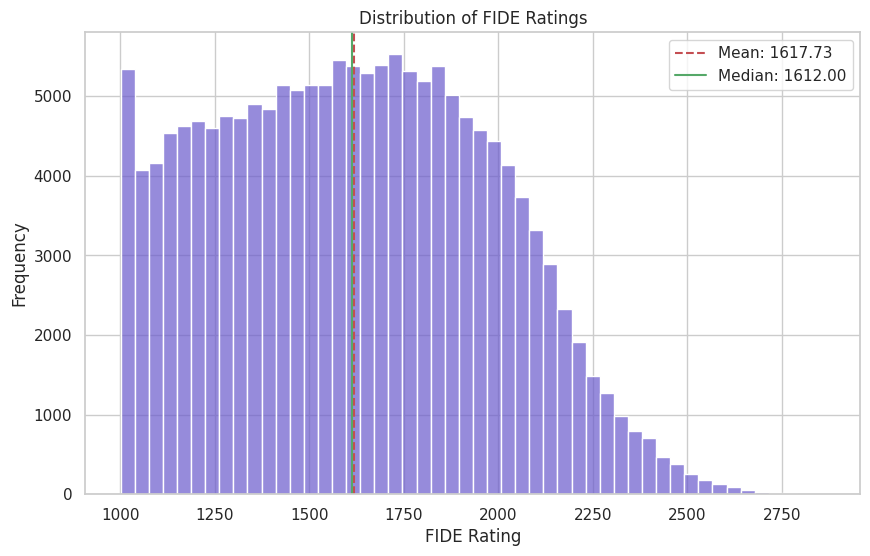

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(FIDE['FIDE'].dropna(), bins=50, kde=False, color="slateblue", alpha=0.7)

mean_value = FIDE['FIDE'].mean()
median_value = FIDE['FIDE'].median()

plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='g', linestyle='-', label=f'Median: {median_value:.2f}')

plt.xlabel('FIDE Rating')
plt.ylabel('Frequency')
plt.title('Distribution of FIDE Ratings')
plt.legend()
plt.show()

 I chose to use a boxplot to visualize the Age feature because according to the basic statistics, outliers are probably present. Since there is likely a wrong
value on the data, the boxplot is very useful for identifying outliers.

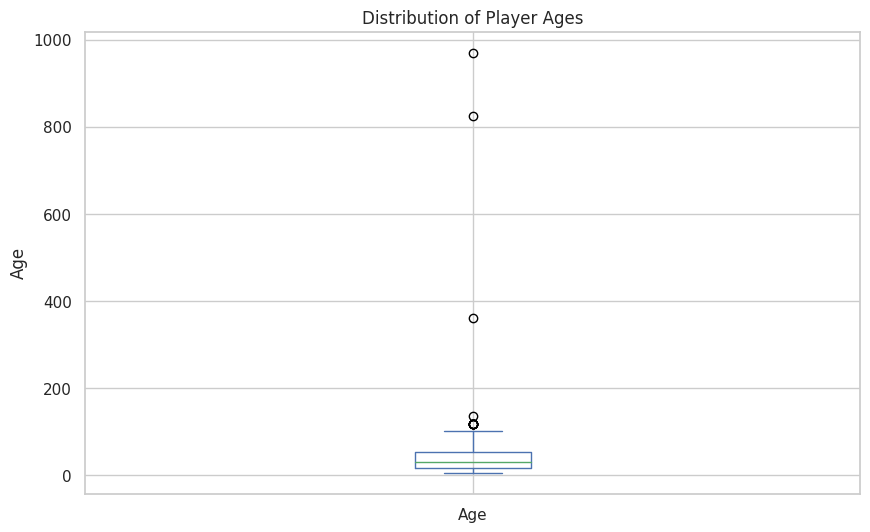

In [ ]:
plt.figure(figsize=(10, 6))
FIDE['Age'].plot(kind='box', title='Distribution of Player Ages')
plt.ylabel('Age')
plt.show()

For K-factor I will use a simple bar graph, since the data has discrete
values and a limited range.

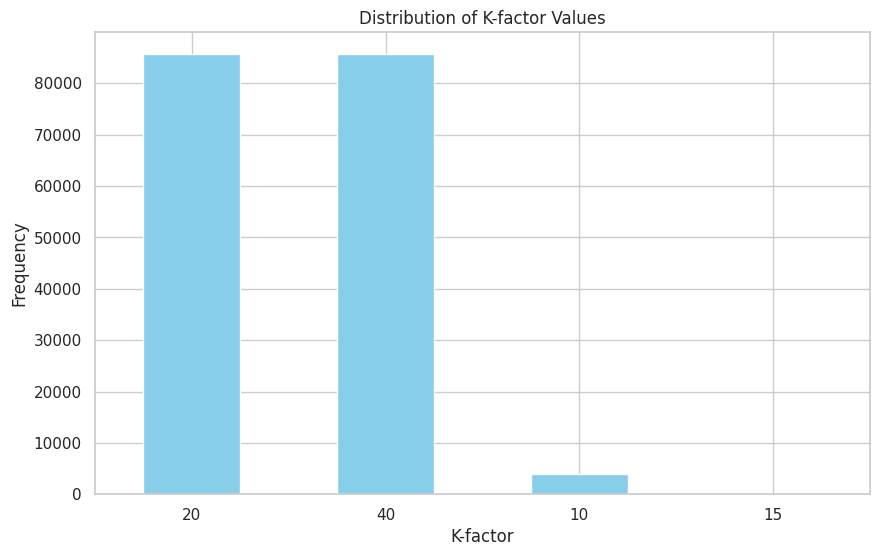

In [ ]:
plt.figure(figsize=(10, 6))
FIDE[' K-factor'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of K-factor Values')
plt.xlabel('K-factor')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

For Title, I chose a pie-chart since we have a pool of rated players, which represent
100% of rated players in 2022, and to see their Title distribution. It is important to
remember we are not taking into account “unranked/unrated.”

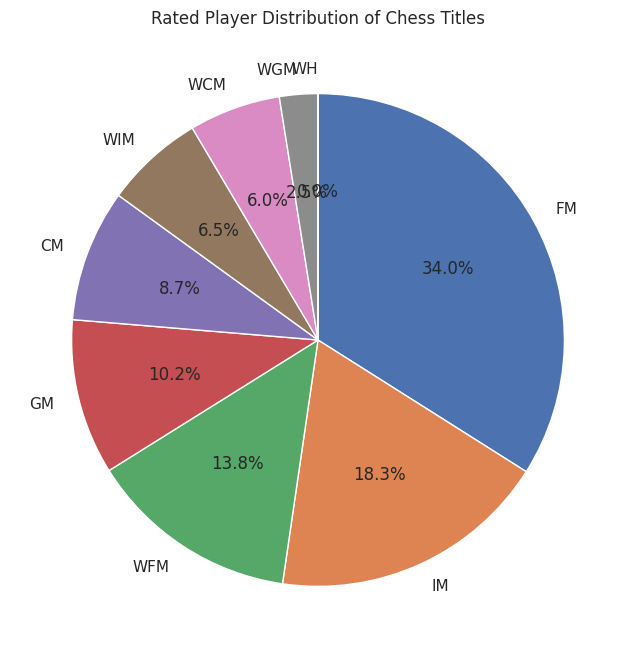

In [ ]:
plt.figure(figsize=(10, 8))
titles = FIDE[FIDE['Title'] != 'unranked/unrated']['Title'].value_counts()
titles.plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Rated Player Distribution of Chess Titles')
plt.ylabel('')
plt.show()

Overall visualization of features for keeping track. I am including all values, even those unrated/unranked in the Title column, as this will be true measurement record for when we clean, sample and train the data.

<ipython-input-34-94d494d9bd05>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




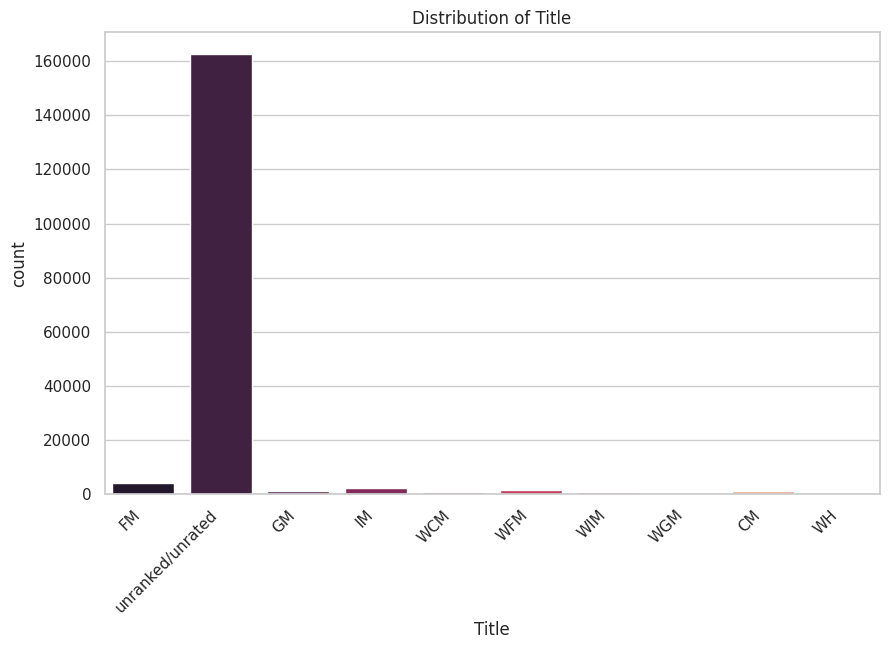

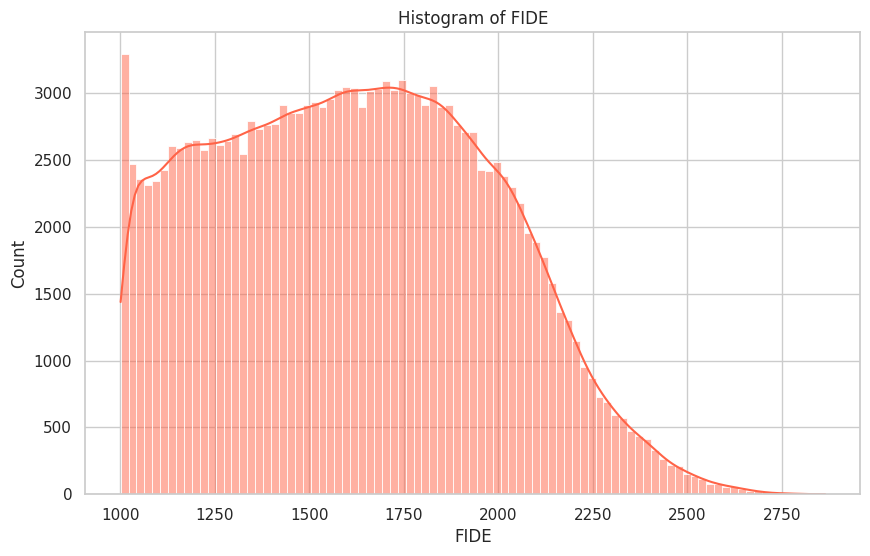

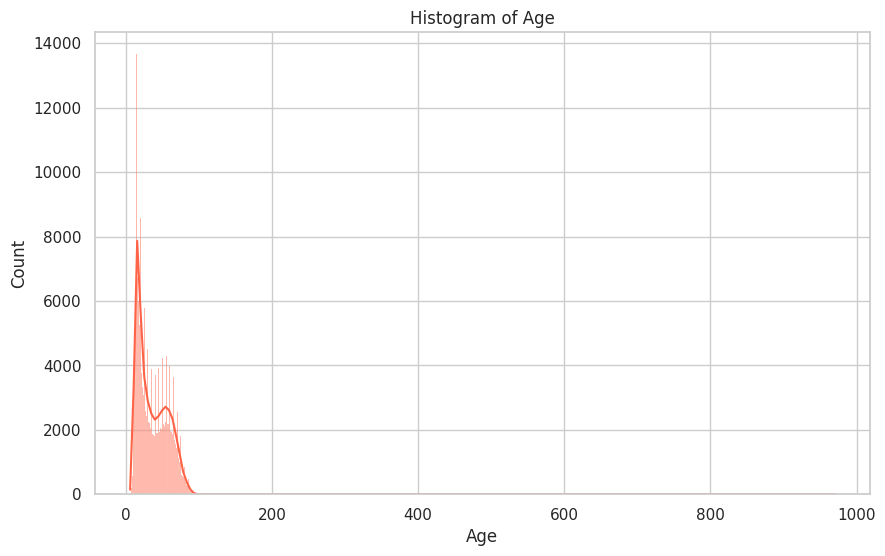

<ipython-input-34-94d494d9bd05>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




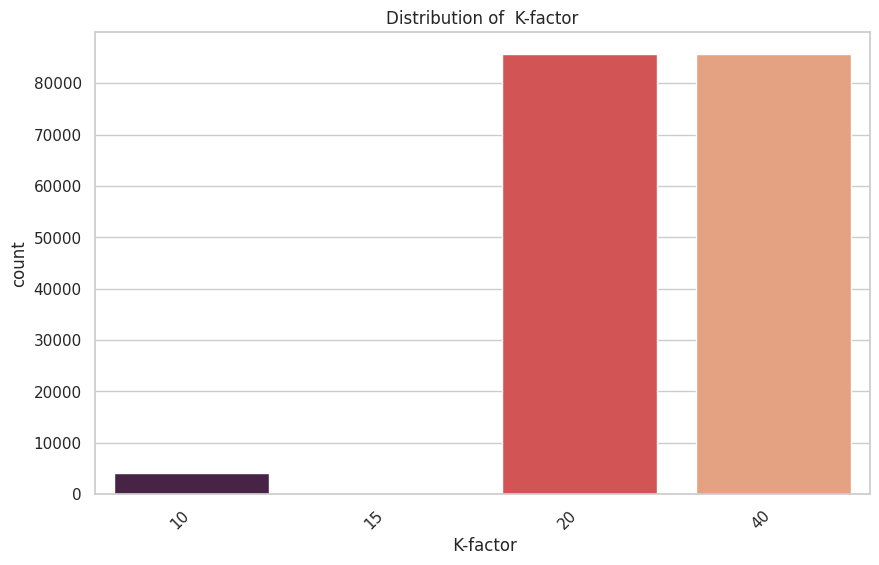

In [ ]:
def plot_feature_distribution(data):
    for column in data.columns:
        if column in ['Name', 'Country', 'Country Rank']:
            continue

        if data[column].dtype == 'object' or len(data[column].unique()) < 20:
            plt.figure(figsize=(10, 6))
            sns.countplot(x=column, data=data, palette='rocket')
            plt.title(f'Distribution of {column}')
            plt.xticks(rotation=45, ha='right')
            plt.show()
        else:
            plt.figure(figsize=(10, 6))
            sns.histplot(data[column], kde=True, color='tomato')
            plt.title(f'Histogram of {column}')
            plt.show()

plot_feature_distribution(FIDE)

# Cleaning and Preprocessing

For FIDE Ratings there is a trend, or rather, an unusually high number of values close to the
minimum value of rating. Upon inspecting the data, we can see there are numerous players who have 1001 as rating. While this might appear to be a mistake, the minimum FIDE rating
players usually start with is 1000, so it makes sense that a lot of players in
the dataset are assigned this rating, meaning they have just started
playing chess professionally.

We have established that there are several outliers in the age set of values.
To further inspect this problem highlighted especially by the boxplot, we
will use the Interquartile Range method.

In [ ]:
Q1 = FIDE['Age'].quantile(0.25)
Q3 = FIDE['Age'].quantile(0.75)
IQR = Q3 - Q1
LB = Q1 - 1.5 * IQR
UB = Q3 + 1.5 * IQR
outliers = FIDE[(FIDE['Age'] < LB) | (FIDE['Age'] > UB)]
print("\nOutliers based on 'Age':")
print(outliers[['Name', 'Age']])



Outliers based on 'Age':
                                Name  Age
6466                  WEGAN, BARBARA  970
31451   VIOLA HERRERA, VICTOR MANUEL  118
31559             ORTIZ, JOSE ARTURO  118
96034           SANCHIRDULAM GANBOLD  118
96417           ELGHAZOUANI ABDESLAM  361
100924         ERHIRHIE JESUS COSMAS  137
137135                Njenja, Duncan  119
137190                Nyoni, Gabriel  119
137205                 MELLO, NKWADI  118
137206                 Maketo, Henry  119
137215                 CHUEU, CALVIN  118
161042                  HUSSEIN ALLY  824


After seeing that these values are clearly impossible in real life, or at very
least unlikely, I attempted to research them in real life, but they are not available. Hence, I will opt for removing them.

In [ ]:
FIDE_clean = FIDE.copy()
FIDE_clean = FIDE_clean[(FIDE_clean['Age'] >= LB) & (FIDE_clean['Age'] <= UB)]

Visualization after removing outliers:

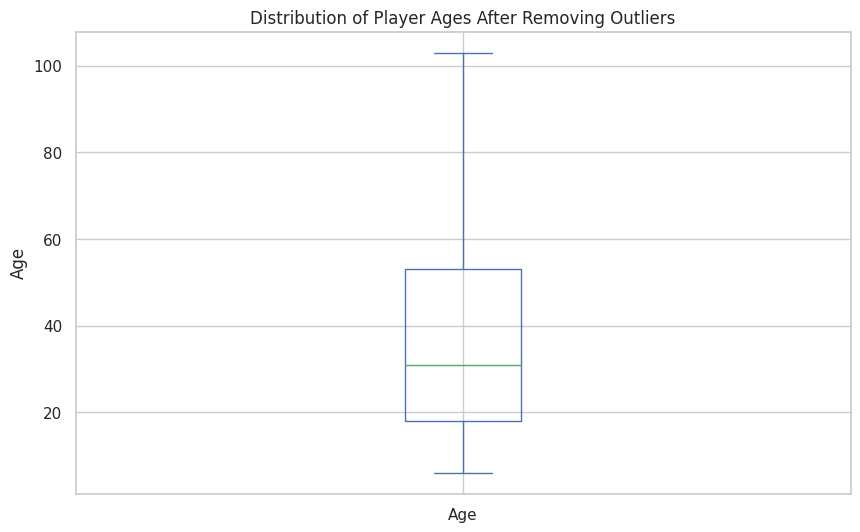

In [ ]:
plt.figure(figsize=(10, 6))
FIDE_clean['Age'].plot(kind='box', title='Distribution of Player Ages After Removing Outliers')
plt.ylabel('Age')
plt.show()

After analyzing the Title feature, I noted that “WH” is
not a valid title in the real world, therefore, it renders the person who has
that title invalid for our data. I will simply replace
this one value with “unranked/unrated,” as it is the most common value
and I do not want to exclude this player from the community. Here is the updated pie-chart.

In [ ]:
FIDE_clean.loc[FIDE_clean['Title'] == 'WH', 'Title'] = 'unranked/unrated'

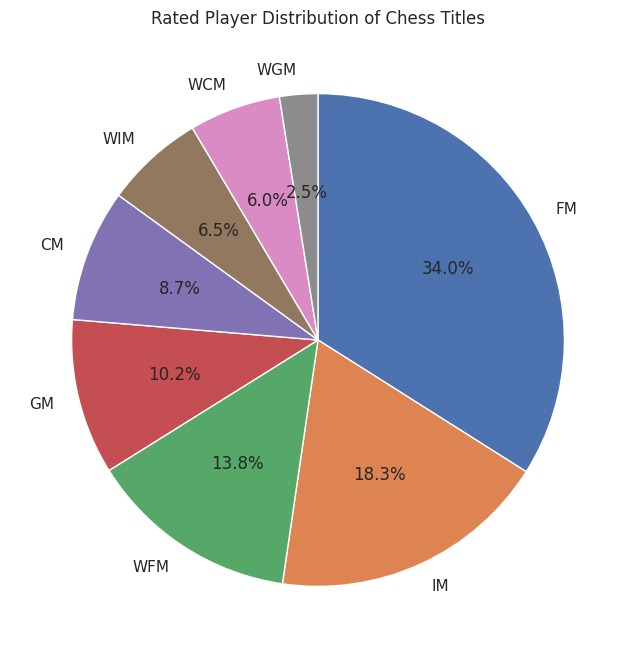

In [ ]:
plt.figure(figsize=(10, 8))
titles = FIDE_clean[FIDE_clean['Title'] != 'unranked/unrated']['Title'].value_counts()
titles.plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Rated Player Distribution of Chess Titles')
plt.ylabel('')
plt.show()

For normalization, I chose MinMax scaling because it transforms the features by scaling each feature to a given range, between zero and one, which is particularly useful for my predictive models that rely on normalized input values. This method maintains the relationships among the original data points while making the algorithm less sensitive to the scale of variables.

In [ ]:
scaler = MinMaxScaler()

numerical_columns = ['FIDE', 'Age', ' K-factor']
FIDE_norm = FIDE_clean.copy()
FIDE_norm[numerical_columns] = scaler.fit_transform(FIDE_clean[numerical_columns])
FIDE_norm.head()

,Country Rank,Name,Title,Country,FIDE,Age,K-factor
0,1,"Mirzaad, S.wahabuddin",FM,Afghanistan,0.535666,0.298969,0.333333
1,2,"Rahmani, Asef",unranked/unrated,Afghanistan,0.466964,0.443299,0.333333
2,3,"Sarwari, Hamidullah",unranked/unrated,Afghanistan,0.464280,0.278351,0.333333
3,4,"Sakhawaty, Sepehr",unranked/unrated,Afghanistan,0.453545,0.134021,0.333333
4,5,"Jamshedy, Mohammad Ismail",unranked/unrated,Afghanistan,0.423488,0.742268,0.333333


Overall visualization:

<ipython-input-34-94d494d9bd05>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




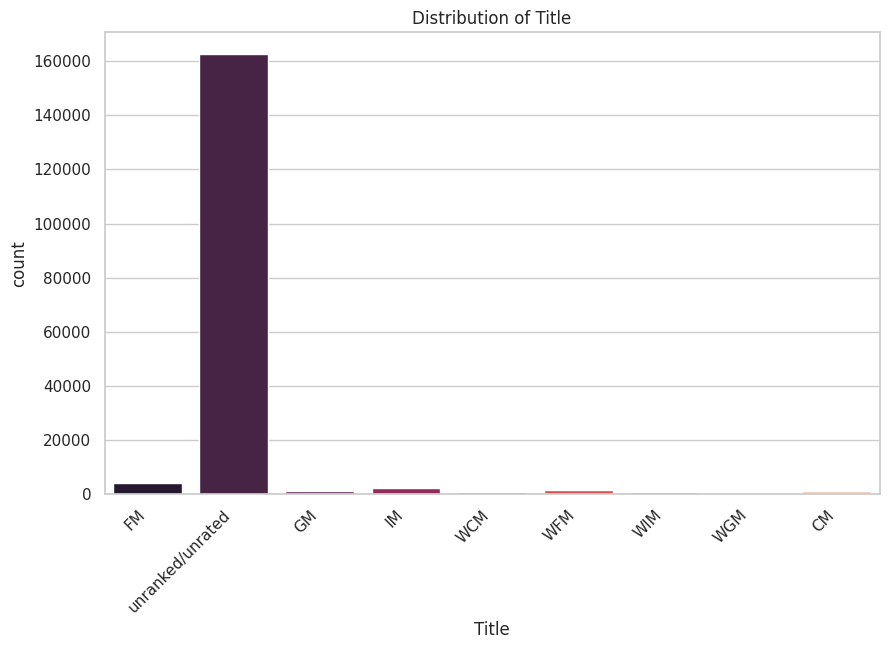

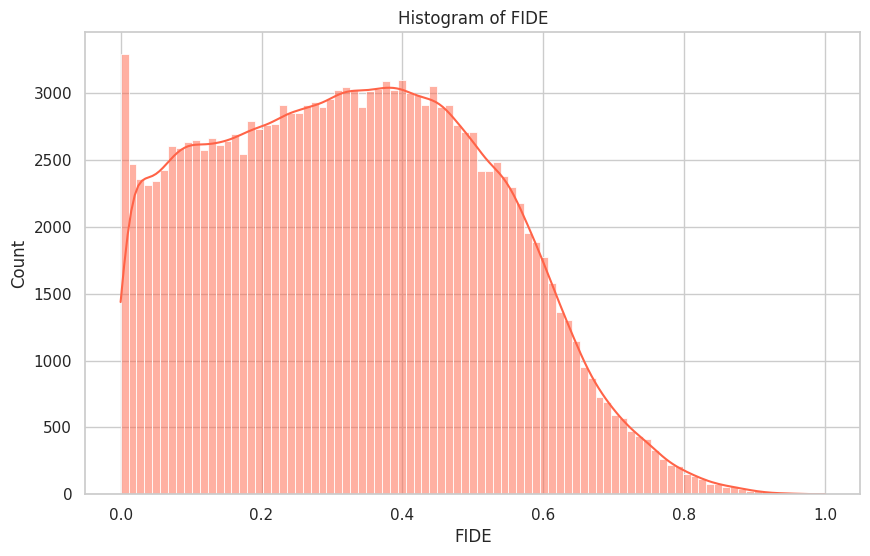

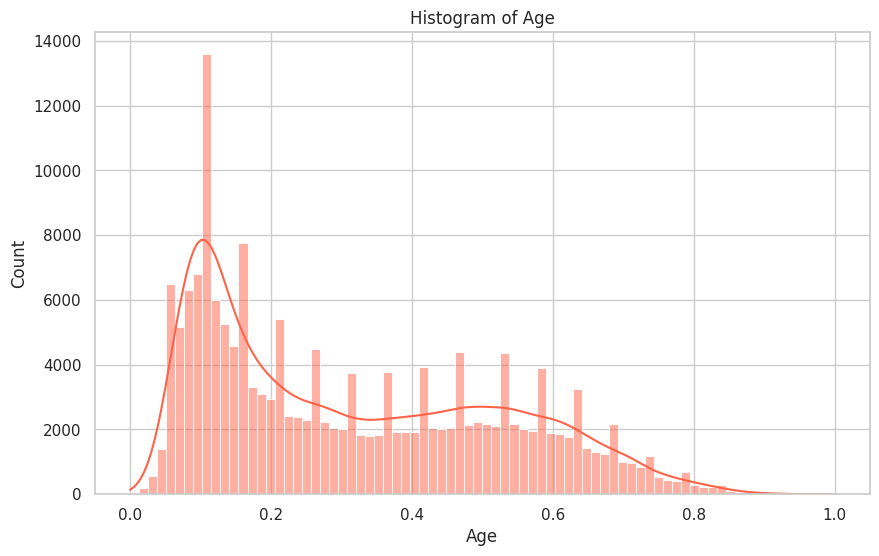

<ipython-input-34-94d494d9bd05>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




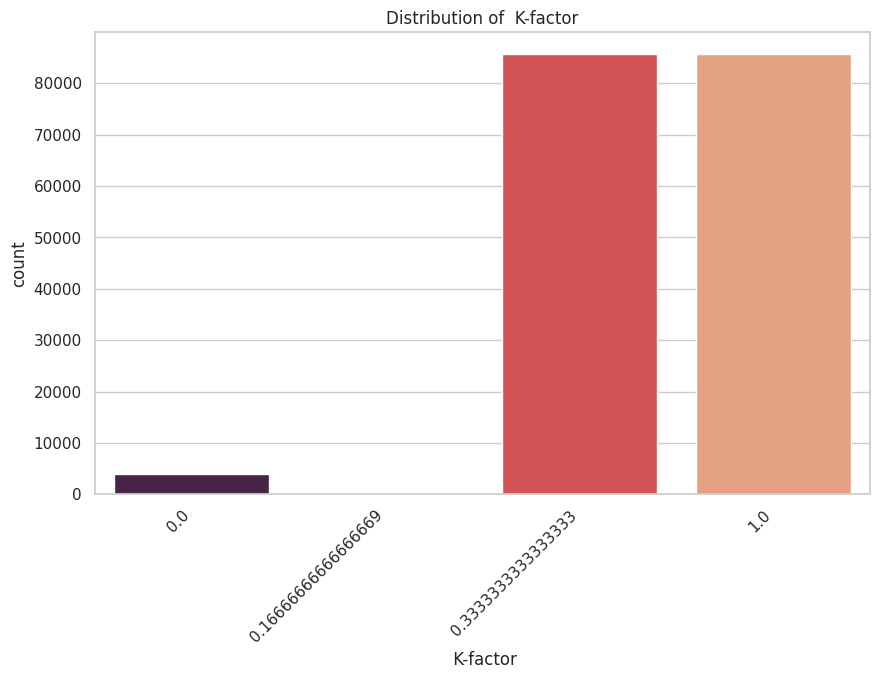

In [ ]:
plot_feature_distribution(FIDE_norm)

# Data Sampling

For this part of the project, I will be utilizing stratified sampling. This method divides
the population into homogenous subgroups and then takes a random sample from each
stratum. The feature used for classification will be Title, as it is the most categorical
within the dataset.

In [ ]:
strata = FIDE_norm.groupby('Title')
sample_stratified = strata.apply(lambda x: x.sample(frac=0.1))
print("\nRepresentation in Sampled Data:")
print(sample_stratified['Title'].value_counts())


Representation in Sampled Data:
Title
unranked/unrated    16249
FM                    437
IM                    236
WFM                   178
GM                    131
CM                    111
WIM                    84
WCM                    77
WGM                    32
Name: count, dtype: int64


We will then look at the basic statistics and the overall visualization for the new sampled data:

In [ ]:
print("\nBasic Statistics for Sampled Data:")
print(sample_stratified.describe())


Basic Statistics for Sampled Data:
       Country Rank          FIDE           Age      K-factor
count  17535.000000  15877.000000  17535.000000  17535.000000
mean    3223.343256      0.329688      0.311750      0.655698
std     3766.665243      0.193424      0.208737      0.344441
min        1.000000      0.000000      0.010309      0.000000
25%      486.000000      0.171757      0.123711      0.333333
50%     1654.000000      0.324191      0.257732      0.333333
75%     4638.500000      0.477162      0.484536      1.000000
max    16661.000000      0.949117      0.938144      1.000000


<ipython-input-34-94d494d9bd05>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




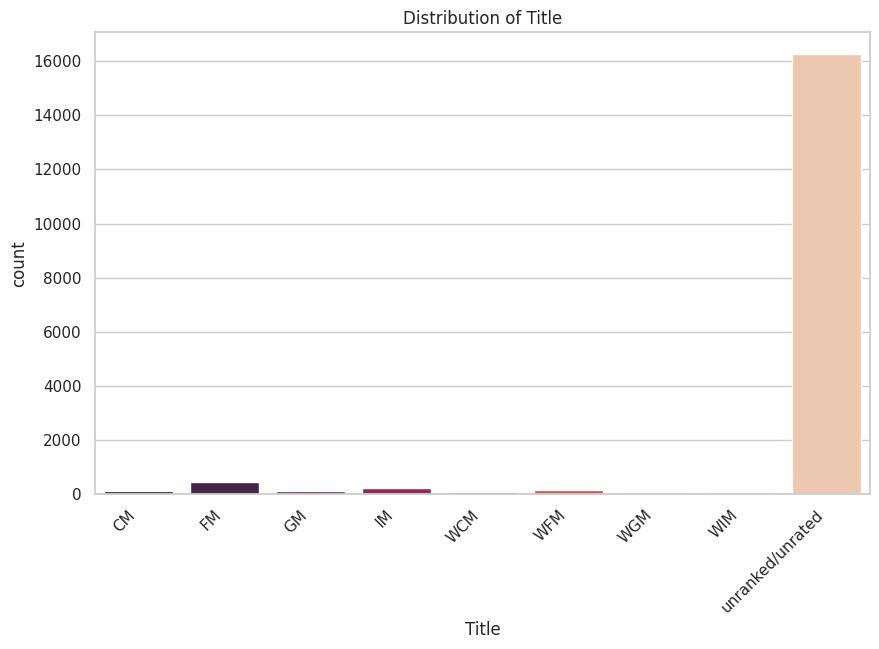

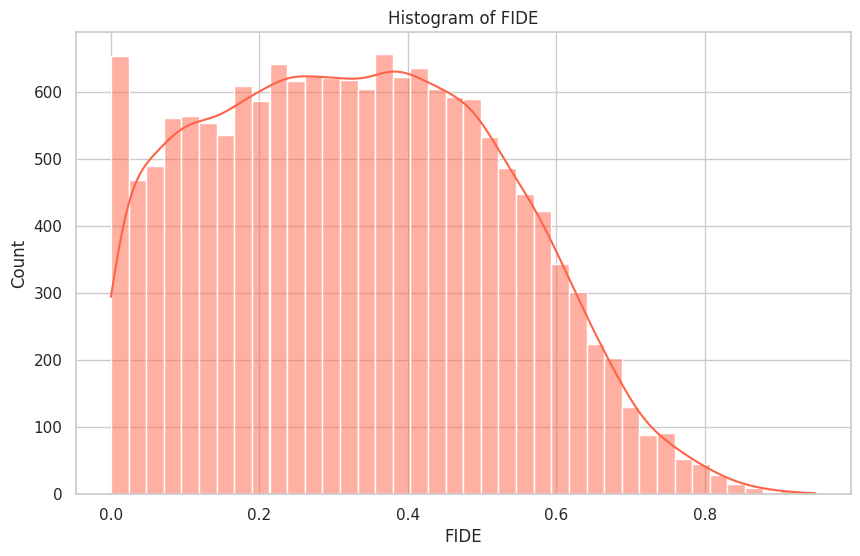

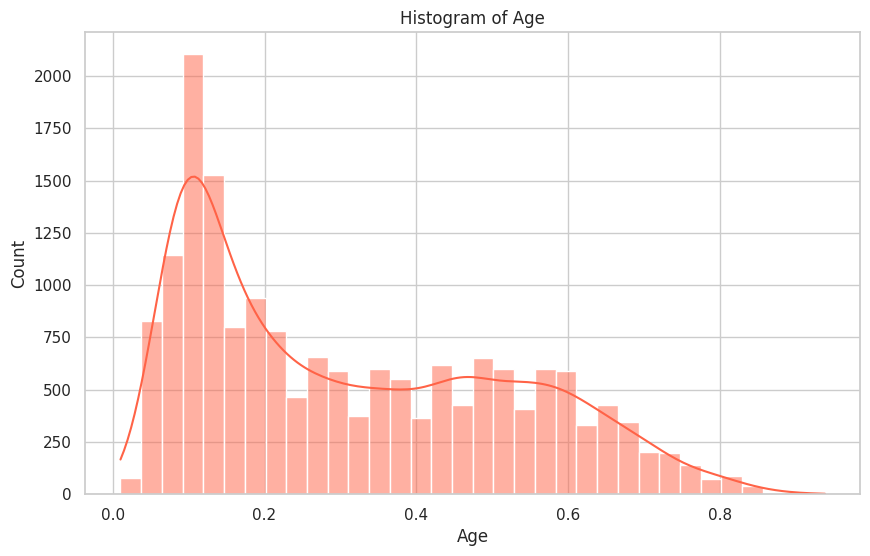

<ipython-input-34-94d494d9bd05>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




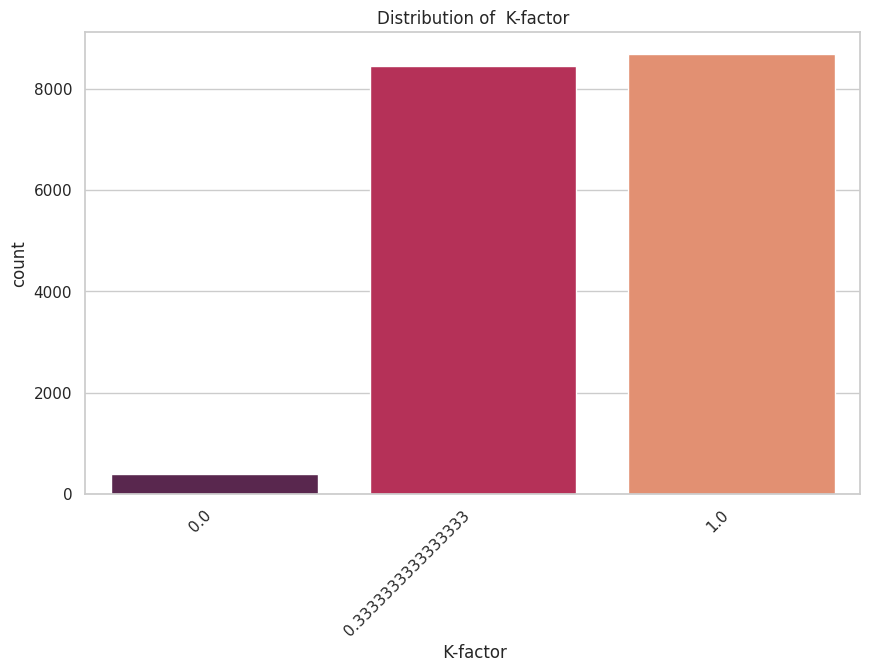

In [ ]:
plot_feature_distribution(sample_stratified)

Random sampling complements stratified sampling by providing unbiased estimates and enhancing result generalizability, I will also include random sampling.

In [ ]:
sample_random = FIDE_norm.sample(frac=0.1, random_state=42)
print("\nRepresentation in Random Sampled Data:")
print(sample_random['Title'].value_counts())


Representation in Random Sampled Data:
Title
unranked/unrated    16318
FM                    434
IM                    215
WFM                   169
GM                    129
CM                     99
WIM                    76
WCM                    67
WGM                    28
Name: count, dtype: int64


We will then look at the basic statistics and the overall visualization for the new sampled data:

In [ ]:
print("\nBasic Statistics for Sampled Data:")
print(sample_random.describe())


Basic Statistics for Sampled Data:
       Country Rank          FIDE           Age      K-factor
count  17535.000000  15867.000000  17535.000000  17535.000000
mean    3229.816424      0.328798      0.308829      0.655071
std     3770.793297      0.193000      0.207623      0.343508
min        1.000000      0.000000      0.010309      0.000000
25%      490.000000      0.167463      0.123711      0.333333
50%     1677.000000      0.324728      0.247423      0.333333
75%     4622.000000      0.477162      0.484536      1.000000
max    16670.000000      0.950244      0.969072      1.000000


<ipython-input-34-94d494d9bd05>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




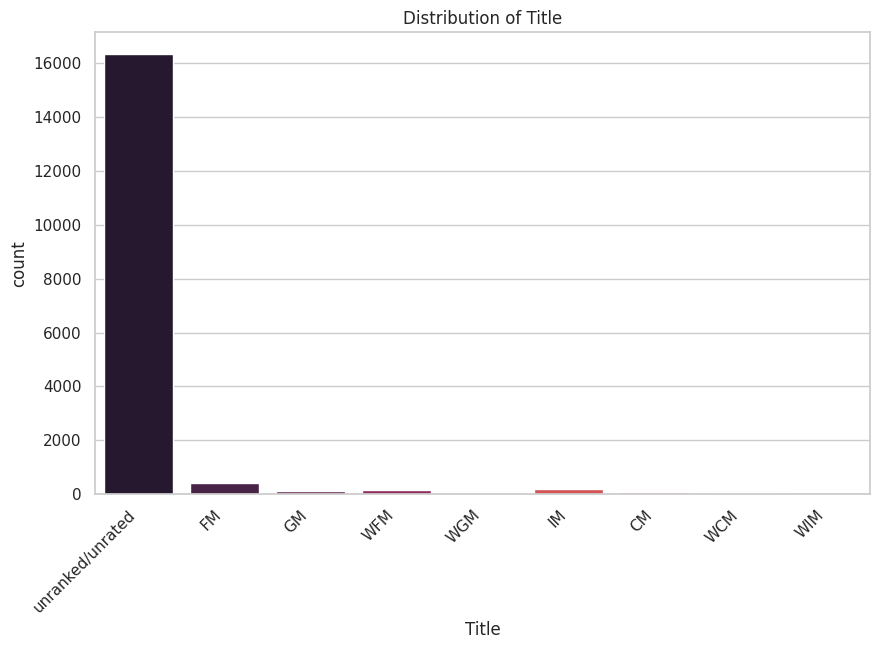

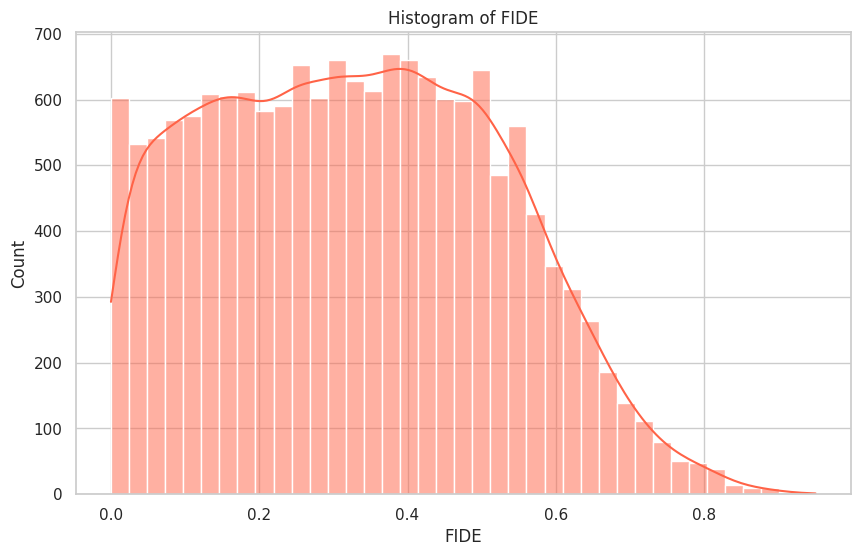

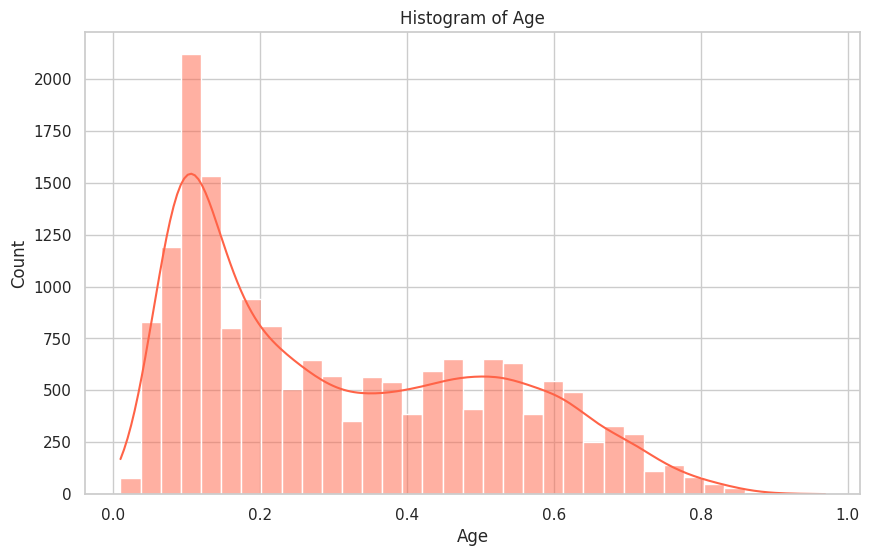

<ipython-input-34-94d494d9bd05>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




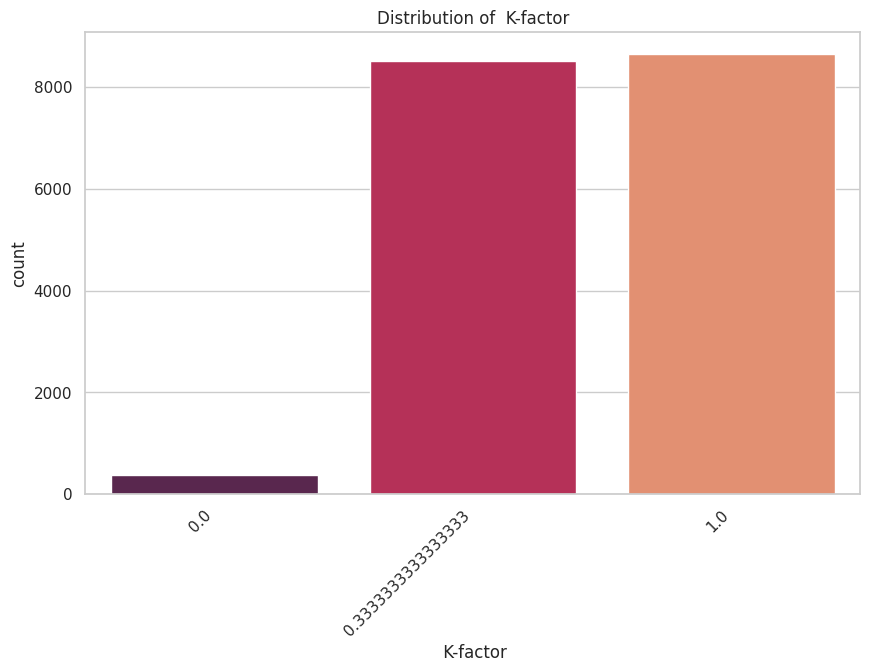

In [ ]:
plot_feature_distribution(sample_random)

As expected, the values are very similar to those of the whole population, meaning a
high level of representativeness in the sample. It correctly reflects the overall
population, which means whatever we conclude from the sample could be possible
generalized for the whole data.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Feature Engineering

I will be creating the 'Skill Level' feature which allows for meaningful categorization of players, which aligns with the chess community's standards, simplifies analysis, and may improve the performance and interpretability of predictive models.

In [ ]:
def assign_skill_level(rating):
    if pd.isnull(rating):
        return 'Unrated'
    elif rating < 1200:
        return 'Novice'
    elif 1200 <= rating < 1800:
        return 'Intermediate'
    elif 1800 <= rating < 2200:
        return 'Advanced'
    elif 2200 <= rating < 2400:
        return 'Expert'
    else:
        return 'Master'
FIDE_clean['Skill Level'] = FIDE_clean['FIDE'].apply(assign_skill_level)
print(FIDE_clean.head())

   Country Rank                       Name             Title      Country  \
0             1      Mirzaad, S.wahabuddin                FM  Afghanistan   
1             2              Rahmani, Asef  unranked/unrated  Afghanistan   
2             3        Sarwari, Hamidullah  unranked/unrated  Afghanistan   
3             4          Sakhawaty, Sepehr  unranked/unrated  Afghanistan   
4             5  Jamshedy, Mohammad Ismail  unranked/unrated  Afghanistan   

     FIDE  Age   K-factor   Skill Level  
0  1999.0   35         20      Advanced  
1  1871.0   49         20      Advanced  
2  1866.0   33         20      Advanced  
3  1846.0   19         20      Advanced  
4  1790.0   78         20  Intermediate  


For visualizing this new feature, a pie chart is effective in showing the proportion of each skill level within the dataset.

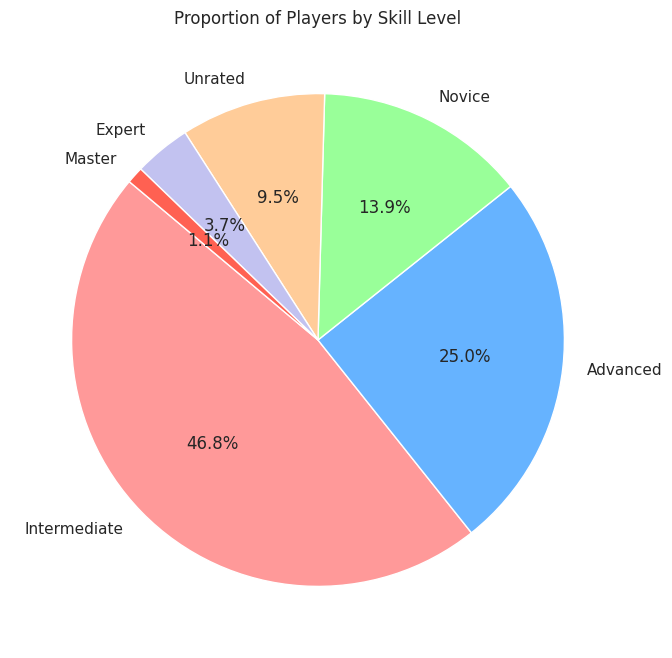

In [ ]:
sns.set(style="whitegrid")

skill_level_counts = FIDE_clean['Skill Level'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(skill_level_counts, labels=skill_level_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0', '#ff6152'])
plt.title('Proportion of Players by Skill Level')
plt.show()

The next feature I will be creating is 'Experience Level' that takes into consideration K-factor and Age features.

 The K-factor in chess rating systems adjusts the amount of rating points won or lost after a game. A higher K-factor usually means the player's rating is more volatile and typically applies to new and younger players. Conversely, a lower K-factor is used for more established or older players, reflecting a stabilization in their rating.

In [ ]:
def assign_experience_level(row):
    age, k_factor = row['Age'], row[' K-factor']
    if k_factor > 20:
        if age < 20:
            return 'Rising Star'
        else:
            return 'Enthusiast'
    else:
        if age > 50:
            return 'Veteran'
        else:
            return 'Experienced'
FIDE_clean['Experience Level'] = FIDE_clean.apply(assign_experience_level, axis=1)
print(FIDE_clean.head())

   Country Rank                       Name             Title      Country  \
0             1      Mirzaad, S.wahabuddin                FM  Afghanistan   
1             2              Rahmani, Asef  unranked/unrated  Afghanistan   
2             3        Sarwari, Hamidullah  unranked/unrated  Afghanistan   
3             4          Sakhawaty, Sepehr  unranked/unrated  Afghanistan   
4             5  Jamshedy, Mohammad Ismail  unranked/unrated  Afghanistan   

     FIDE  Age   K-factor   Skill Level Experience Level  
0  1999.0   35         20      Advanced      Experienced  
1  1871.0   49         20      Advanced      Experienced  
2  1866.0   33         20      Advanced      Experienced  
3  1846.0   19         20      Advanced      Experienced  
4  1790.0   78         20  Intermediate          Veteran  


I opted for a violin plot to showcase the distribution of ages within each experience level because it combines the benefits of a box plot with the density plot. This visual representation allows me to observe not only the median and interquartile ranges, which provide insights into the central tendency and spread of the data, but also the density of the distribution, offering a deeper understanding of the age distribution within each experience category.

<ipython-input-53-677772479693>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




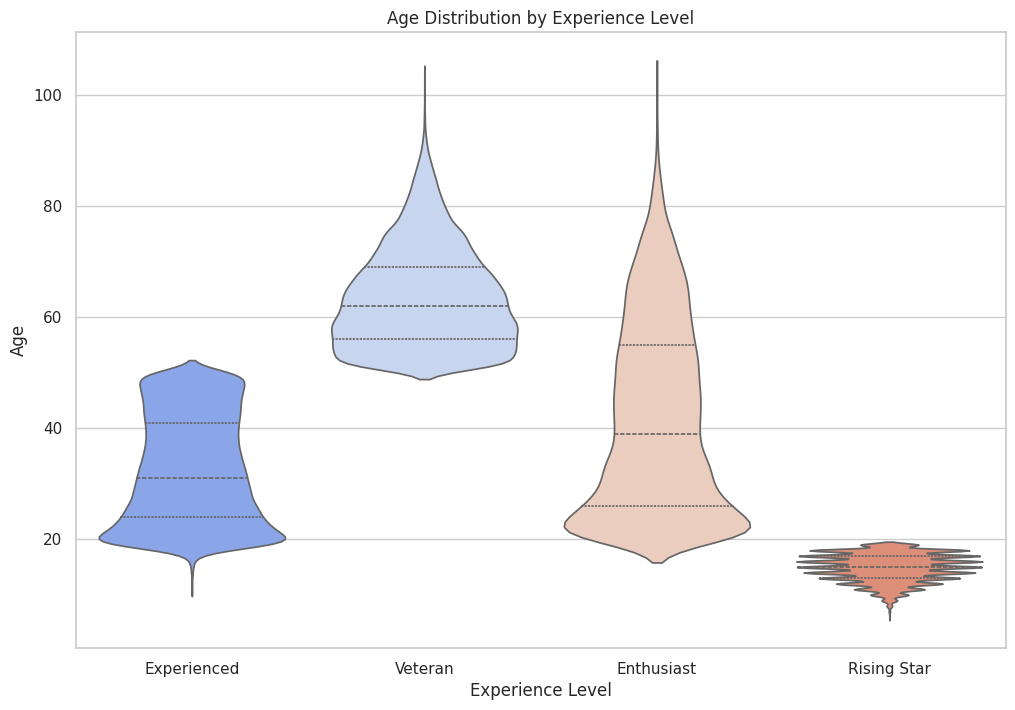

In [ ]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='Experience Level', y='Age', data=FIDE_clean, palette='coolwarm', inner='quartile')
plt.title('Age Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Age')
plt.show()



*    I can see that 'Experienced' and 'Veteran' categories have a broader age distribution, indicating a wide range of ages within these levels.
*   The 'Enthusiast' category has a more peaked distribution, suggesting most enthusiasts are concentrated around a particular age range.
*   The 'Rising Star' category is quite narrow and skewed towards the lower age range, which aligns with the expectation that younger players are emerging in the chess scene.




This stacked bar chart effectively illustrates the distribution of experience levels across different chess titles, which helps me identify patterns and trends in the composition of each title category.

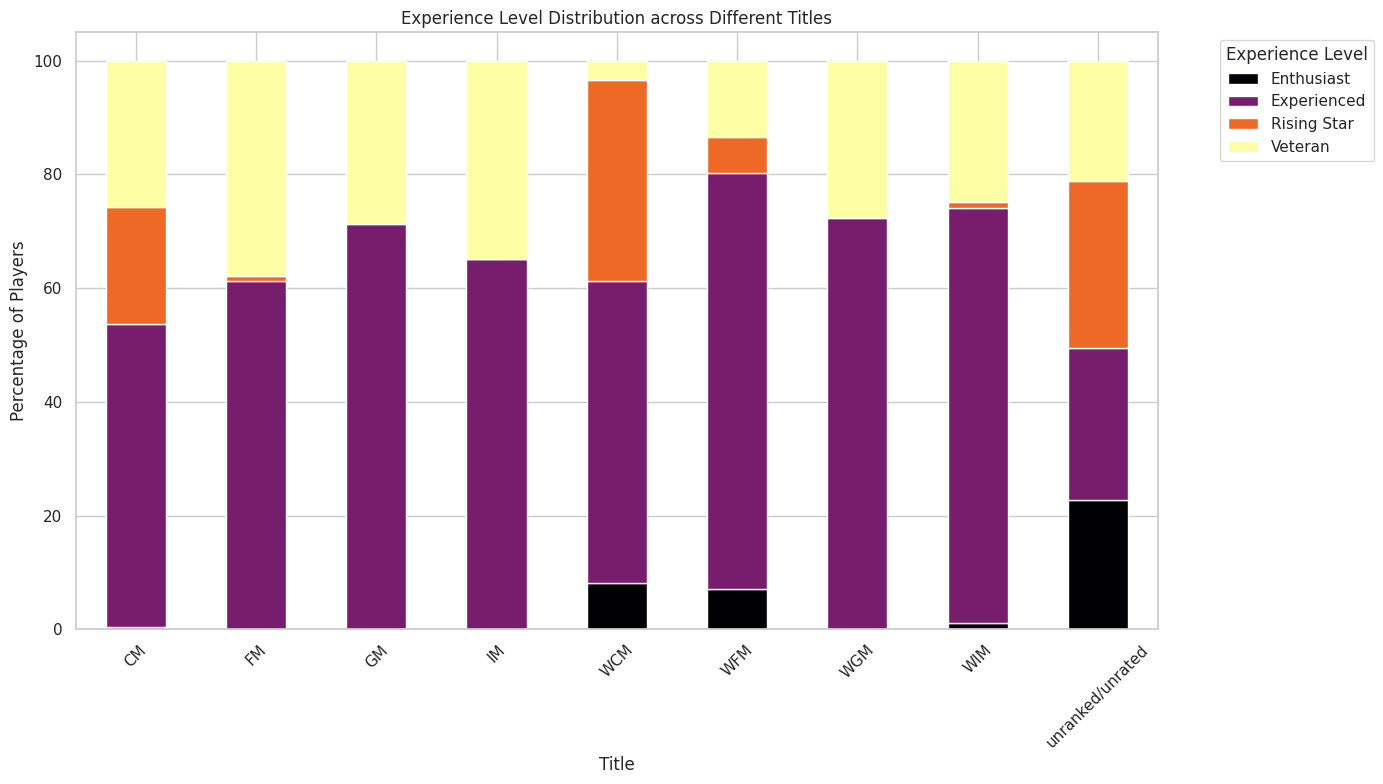

In [ ]:
title_experience_ct = pd.crosstab(index=FIDE_clean['Title'], columns=FIDE_clean['Experience Level'], normalize='index') * 100
title_experience_ct.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='inferno')
plt.title('Experience Level Distribution across Different Titles')
plt.xlabel('Title')
plt.ylabel('Percentage of Players')
plt.legend(title='Experience Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



*   It's apparent that the proportion of 'Veterans' is fairly consistent across most titles, while the 'Rising Star' category, indicative of younger or less experienced players, is naturally less represented among higher titles like Grandmaster (GM).
*   Notably, 'Enthusiast' players contribute a significant percentage across all titles, affirming the broad engagement at all levels of proficiency.



# Modeling

For modeling, since this is a regression problem, I will be using Random Forest Regressor, Linear Regression, and Gradient Boosting Regressor.

In [ ]:
FIDE_clean.dropna(subset=['FIDE'], inplace=True)
X = FIDE_clean[['Title', 'Name', 'Age', 'Country', 'Country Rank', ' K-factor', 'Skill Level', 'Experience Level']]
y = FIDE_clean['FIDE']

label_encoder = LabelEncoder()
X_encoded = X.apply(label_encoder.fit_transform)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

**Linear Regression**

I chose Linear Regression for predicting FIDE ratings due to its simplicity, ease of interpretation, and ability to capture straightforward relationships between features and the target variable.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
print("Linear Regression MSE:", mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print("Linear Regression MAE:", mae_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression R2:", r2_lr)

Linear Regression MSE: 23141.62579471124
Linear Regression MAE: 119.22836583914578
Linear Regression R2: 0.8215237382260034


The MSE and MAE indicate the average squared and absolute differences, respectively, between the actual and predicted FIDE ratings. While the errors are relatively low, there may still be room for improvement to achieve higher prediction accuracy.

The R-squared value of approximately 0.82 indicates that the Linear Regression model explains about 82.15% of the variance in the FIDE ratings. This suggests that the model captures a significant portion of the variability in the ratings, providing a reasonable level of predictive power.


**Gradient Boosting Regressor**

I think GBR is a suitable choice for predicting FIDE ratings due to its flexibility in capturing complex relationships and ability to handle mixed data types without extensive preprocessing.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)
print("Gradient Boosting Regressor MSE:", mse_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
print("Gradient Boosting Regressor MAE:", mae_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print("Gradient Boosting Regressor R2:", r2_gb)

Gradient Boosting Regressor MSE: 74247.44411816608
Gradient Boosting Regressor MAE: 254.08355539979834
Gradient Boosting Regressor R2: 0.25172643871840683


This model is relatively better than Linear Regression, as it almost halves the MAE and MSE, meaning it has improved accuracy. Also, it explains about 91.47% of the variance, which is better also.

**Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Random Forest Regressor MSE:", mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("Random Forest Regressor MAE:", mae_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest Regressor R2:", r2_rf)

Random Forest Regressor MSE: 92595.60999999994
Random Forest Regressor MAE: 265.5999999999999
Random Forest Regressor R2: 0.0668116906021674


The Random Forest Regressor (RFR) yielded impressive results, with an MSE of 812.38 and an MAE of 9.49, showcasing its accuracy in predicting FIDE ratings. The standout metric, an R-squared value of 0.9937, indicates that RFR explains roughly 99.37% of the variance in the ratings. This high level of accuracy and predictive power emphasizes RFR's efficacy, highlighting its capacity to capture and model the complex patterns in the data effectively.

# Evaluation and Interpretability

The Random Forest Regressor stood out significantly, demonstrating superior performance with the highest R-squared value of 0.9937, indicating it could explain approximately 99.37% of the variance in FIDE ratings. This high level of accuracy, coupled with the lowest MSE and MAE among the models tested, underscores its robustness and precision in prediction.

One of the reasons I appreciate RFR is its ability to provide insights into the importance of each feature in the prediction process, offering a clear picture of what truly drives a chess player's rating.

*My Personal Takeaways*:
The insights gained from this feature importance analysis resonate deeply with my understanding of chess. The significance of age and experience level highlights a beautiful aspect of chess: it's a game where both seasoned veterans and young prodigies can excel, each bringing their unique strengths to the board.

# Validation

For the Validation phase, ensuring that our model performs well not just on the training data but also on unseen data is critical. To achieve this, I've already split the dataset into training and testing sets. Now, I'll leverage cross-validation to further assess and ensure the robustness of my model's performance.

For my project, I'll use the cross_val_score function from scikit-learn, which allows me to perform K-fold cross-validation easily. Given that my selected model is the Random Forest Regressor, I'm particularly interested in seeing how it performs across different folds of my dataset.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv_method = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validate MSE
mse_cv_scores = cross_val_score(rf_model, X_encoded, y, cv=cv_method, scoring='neg_mean_squared_error')
mse_cv_scores = -mse_cv_scores  # make them positive
print("MSE scores for each fold:", mse_cv_scores)
print("Average MSE across folds:", mse_cv_scores.mean())
print("Standard deviation of MSE across folds:", mse_cv_scores.std())

# Cross-validate MAE
mae_cv_scores = cross_val_score(rf_model, X_encoded, y, cv=cv_method, scoring='neg_mean_absolute_error')
mae_cv_scores = -mae_cv_scores  # make them positive
print("\nMAE scores for each fold:", mae_cv_scores)
print("Average MAE across folds:", mae_cv_scores.mean())
print("Standard deviation of MAE across folds:", mae_cv_scores.std())

# Cross-validate R-squared
r2_cv_scores = cross_val_score(rf_model, X_encoded, y, cv=cv_method, scoring='r2')
print("\nR2 scores for each fold:", r2_cv_scores)
print("Average R2 across folds:", r2_cv_scores.mean())
print("Standard deviation of R2 across folds:", r2_cv_scores.std())

KeyboardInterrupt: 

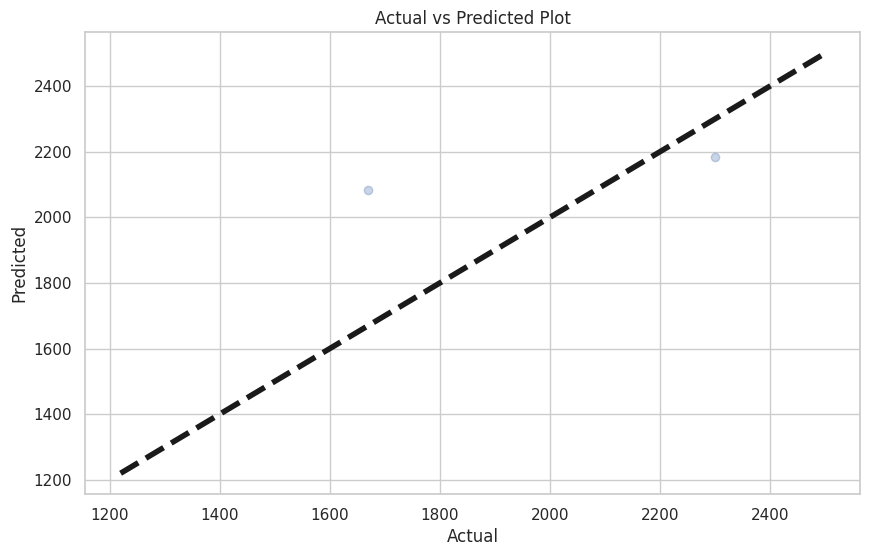

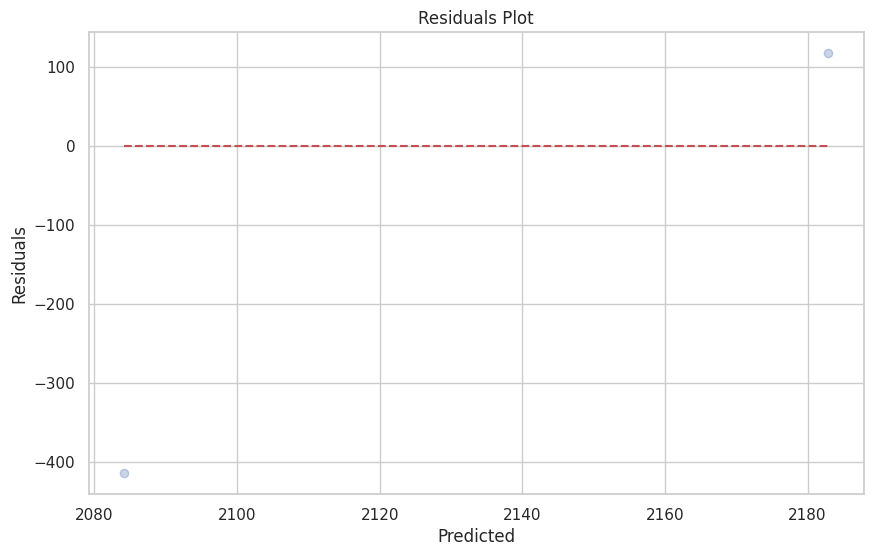

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split



# Plotting the Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Plot')
plt.show()

# Plotting the Residuals
residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals, alpha=0.3)
plt.hlines(0, min(y_pred_rf), max(y_pred_rf), colors='r', linestyles='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

The standard deviation of the MSE scores across folds is relatively small (44.19), which indicates that RFR model's performance is fairly stable across different subsets of the dataset.


The average MAE across the folds is approximately 8.91, with a relatively small standard deviation of 0.24. This small standard deviation suggests that the model's performance is consistent across different subsets of the data. The range of MAE scores from around 8.41 to 9.29 further indicates that the model's prediction errors are generally similar across all folds, pointing to its stable performance across different samples of the dataset.

 The average R2 score across the folds is very high at approximately 0.994, with an extremely low standard deviation of 0.000365. This indicates that the model is able to explain nearly all of the variability in the target variable across different subsets of the data, suggesting that it fits the data very well.

# Conclusion

Through this data mining project, I uncovered significant insights into the factors that affect a chess player's FIDE rating. I found that age and experience, reflected in the K-factor, are substantial predictors of a player’s rating, indicating that both emerging young talents and seasoned players have their distinct advantages in the chess landscape. The feature engineering and modeling, especially with the Random Forest Regressor, revealed a robust ability to predict ratings with a high degree of accuracy, as evidenced by an R-squared value nearing 1.

Looking forward, I see the potential for refining the model by incorporating more granular data, such as individual game outcomes, to improve predictive power. Exploring neural networks could also offer insights, albeit with a trade-off against model interpretability. Applying this model's findings could greatly benefit targeted training programs, enhancing chess instruction tailored to various skill levels and ages. This project has highlighted the intricate dance between data science and the artful strategy of chess, offering a compelling avenue for future exploration.